In [1]:
import keras
from keras.layers import Input, Dense, Flatten, Conv1D, LSTM, Dropout
from keras.models import load_model, Model
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l1
from collections import namedtuple
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from train import parse_config, get_features

from models.models import lstm_model, lstm_model_full

Using TensorFlow backend.


In [2]:
Option = namedtuple("MyStruct", "inputModel inputFile tree config jsonModel outputDir ")
options = Option(
    inputModel = 'KERAS_lstm_model_weights.h5',
    inputFile = 'fixed.z',
    tree = 't_allpar_new',
    config = 'train_config_lstm.yml',
    jsonModel = 'KERAS_lstm_model.json',
    outputDir = 'output'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')

yamlConfig =  yaml.load(config, Loader = yaml.FullLoader)
yamlConfig

Loading configuration from train_config_lstm.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'lstm_model',
 'KerasModelRetrain': 'lstm_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'L1RegR': 0.001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 20}

In [3]:
f = h5py.File(options.inputFile, 'r')
treeArray = f[options.tree][()]

features = yamlConfig['Inputs']
labels = yamlConfig['Labels']

features_df = pd.DataFrame(treeArray,columns=list(set(features)))
labels_df = pd.DataFrame(treeArray,columns=list(set(labels)))

features_labels_df = pd.DataFrame(treeArray,columns = list(set(features + labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_labels_df


,j1_phirot,j_t,j_q,j1_ptrel,j_g,j_z,j1_deltaR,j_w,j_index,j1_etarot,j1_pdgid,j1_erel
0,0.000000,0,0,0.386118,1,0,0.011056,0,101333,0.000000,130.0,0.382772
1,0.007236,0,0,0.107734,1,0,0.023104,0,101333,-0.009859,211.0,0.105703
2,-0.002759,0,0,0.094731,1,0,0.006306,0,101333,0.004508,321.0,0.094339
3,-0.014909,0,0,0.042086,1,0,0.022473,0,101333,0.028567,211.0,0.042913
4,-0.003745,0,0,0.039412,1,0,0.025492,0,101333,-0.018020,-211.0,0.038547
...,...,...,...,...,...,...,...,...,...,...,...,...
5131608,-0.315306,0,0,0.000350,0,1,0.380018,0,300123134,-0.300495,111.0,0.000344
5131609,-0.349366,0,0,0.000258,0,1,0.294476,0,300123134,0.258936,111.0,0.000256
5131610,-0.270430,0,0,0.000219,0,1,0.255231,0,300123134,0.269149,111.0,0.000215
5131611,-0.341398,0,0,0.000116,0,1,0.319973,0,300123134,-0.213081,111.0,0.000115


In [4]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)

C:\Users\jjren\LSTM\train.py:33: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5File = h5py.File(options.inputFile)


(5131613,)
('index', 'j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_

# Self_Build Model

In [5]:
l1Reg =  0.0001
l1RegR = 0.001

Inputs = Input(shape = (20,6,))

x = LSTM(16,return_sequences=True,  kernel_regularizer=l1(l1Reg),recurrent_regularizer=l1(l1RegR),activation='relu',kernel_initializer='lecun_uniform',name='lstm_lstm',
         dropout=0.001, recurrent_dropout=0.00001)(Inputs)

x = Flatten()(x)
#x = Dropout(0.1)(x)
predictions = Dense(5, activation='softmax', kernel_initializer='lecun_uniform', name='rnn_densef')(x)
model = Model(inputs=Inputs, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
lstm_lstm (LSTM)             (None, 20, 16)            1472      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 1605      
Total params: 3,077
Trainable params: 3,077
Non-trainable params: 0
_________________________________________________________________


# Load model.py

In [ ]:
model = lstm_model(Input(shape=X_train_val.shape[1:]), y_train_val.shape[1], l1Reg=yamlConfig['L1Reg'] )




# Load from json

In [8]:
from keras.models import model_from_json
json_file = open(options.jsonModel, 'r')
model = model_from_json(json_file.read())
json_file.close()

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
lstm_lstm (LSTM)             (None, 20, 16)            1472      
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 1605      
Total params: 3,077
Trainable params: 3,077
Non-trainable params: 0
_________________________________________________________________


# Full

In [68]:
model= lstm_model_full(Input(shape=X_train_val.shape[1:]), y_train_val.shape[1], yamlConfig['L1Reg'])

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 20, 6)]           0         
_________________________________________________________________
particles_conv0 (Conv1D)     (None, 20, 32)            416       
_________________________________________________________________
particles_conv1 (Conv1D)     (None, 20, 16)            2064      
_________________________________________________________________
lstm (LSTM)                  (None, 20, 72)            25632     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1440)              0         
_________________________________________________________________
rnn_dense2 (Dense)           (None, 128)               184

# Run training

In [6]:
adam = Adam(lr = 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = model.fit(X_train_val, y_train_val, epochs = 100, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/100
1852/1852 [==============================] - 28s 15ms/step - loss: 1.1177 - accuracy: 0.6018 - val_loss: 1.0107 - val_accuracy: 0.6527
Epoch 2/100
1852/1852 [==============================] - 27s 15ms/step - loss: 0.9784 - accuracy: 0.6637 - val_loss: 0.9581 - val_accuracy: 0.6676
Epoch 3/100
1852/1852 [==============================] - 27s 15ms/step - loss: 0.9401 - accuracy: 0.6791 - val_loss: 0.9422 - val_accuracy: 0.6734
Epoch 4/100
1852/1852 [==============================] - 27s 15ms/step - loss: 0.9189 - accuracy: 0.6862 - val_loss: 0.8918 - val_accuracy: 0.6962
Epoch 5/100
1852/1852 [==============================] - 28s 15ms/step - loss: 0.9010 - accuracy: 0.6909 - val_loss: 0.9006 - val_accuracy: 0.6982
Epoch 6/100
1852/1852 [==============================] - 27s 15ms/step - loss: 0.8928 - accuracy: 0.6964 - val_loss: 0.8758 - val_accuracy: 0.7008
Epoch 7/100
1852/1852 [==============================] - 27s 15ms/step - loss: 0.8847 - accuracy: 0.6984 - val_loss: 0

1852/1852 [==============================] - 26s 14ms/step - loss: 0.8278 - accuracy: 0.7153 - val_loss: 0.8419 - val_accuracy: 0.7122
Epoch 57/100
1852/1852 [==============================] - 26s 14ms/step - loss: 0.8299 - accuracy: 0.7135 - val_loss: 0.8502 - val_accuracy: 0.7078
Epoch 58/100
1852/1852 [==============================] - 26s 14ms/step - loss: 0.8282 - accuracy: 0.7162 - val_loss: 0.8289 - val_accuracy: 0.7191
Epoch 59/100
1852/1852 [==============================] - 26s 14ms/step - loss: 0.8269 - accuracy: 0.7158 - val_loss: 0.8398 - val_accuracy: 0.7112
Epoch 60/100
1852/1852 [==============================] - 26s 14ms/step - loss: 0.8269 - accuracy: 0.7151 - val_loss: 0.8397 - val_accuracy: 0.7160
Epoch 61/100
1852/1852 [==============================] - 26s 14ms/step - loss: 0.8267 - accuracy: 0.7154 - val_loss: 0.8364 - val_accuracy: 0.7147
Epoch 62/100
1852/1852 [==============================] - 26s 14ms/step - loss: 0.8266 - accuracy: 0.7158 - val_loss: 0.8269 

In [8]:
model.save('LSTM')
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: LSTM\assets
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
lstm_lstm (LSTM)             (None, 20, 16)            1472      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 1605      
Total params: 3,077
Trainable params: 3,077
Non-trainable params: 0
_________________________________________________________________


# Test

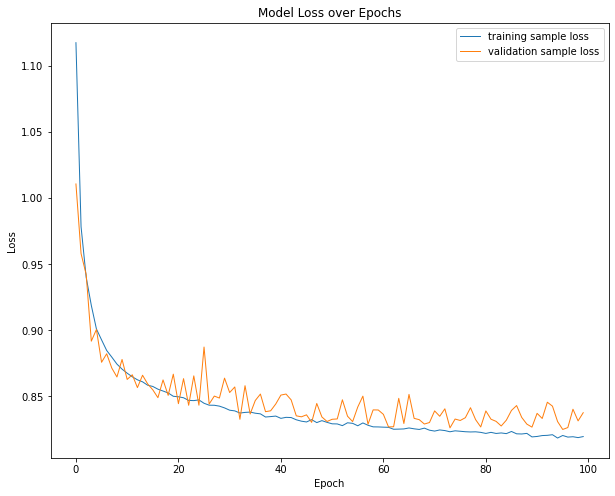

In [9]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

learningCurve(history)

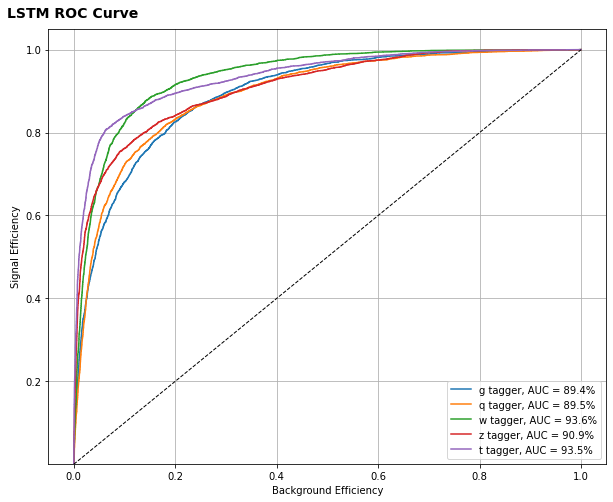

In [10]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'LSTM ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='conv1d')

Text(0.25, 0.9, 'LSTM')

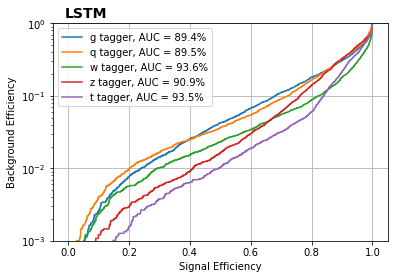

In [11]:
if 'j_index' in labels: labels.remove('j_index')

predict_test = model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'LSTM',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)